<a href="https://colab.research.google.com/github/youssefkamil/Twitter-Sentiment-Analysis/blob/main/Twitter_Sentiment_Analysis_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Report 
- i used glove.twitter.27B with 200 and 25 embedding dimentions
- best accuracy i got : 81%

In [ ]:
!wget http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip

--2020-08-02 22:26:58--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip’

glove.twitter.27B.z 100%[===================>]   1.42G  2.02MB/s    in 11m 43s 

2020-08-02 22:38:41 (2.06 MB/s) - ‘glove.twitter.27B.zip’ saved [1520408563/1520408563]



In [ ]:

!pip install kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kazanova/sentiment140

Saving kaggle.json to kaggle.json
 90% 73.0M/80.9M [00:05<00:00, 9.30MB/s]
100% 80.9M/80.9M [00:05<00:00, 14.7MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import re
import os
import zipfile
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import nltk
nltk.download('punkt')
nltk.download('Stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Error loading Stopwords: Package 'Stopwords' not found in
[nltk_data]     index


False

In [ ]:
local_zip = '/content/glove.twitter.27B.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/drive/My Drive')
zip_ref.close()

In [ ]:
local_zip = '/content/sentiment140.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/data')
zip_ref.close()

cols = ['sentiment','id','date','query_string','user','text']
df = pd.read_csv('/tmp/data/training.1600000.processed.noemoticon.csv', encoding='latin1', names=cols)

In [ ]:
df.head()

,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   sentiment     1600000 non-null  int64 
 1   id            1600000 non-null  int64 
 2   date          1600000 non-null  object
 3   query_string  1600000 non-null  object
 4   user          1600000 non-null  object
 5   text          1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [ ]:
df['sentiment'].value_counts()

1    800000
0    800000
Name: sentiment, dtype: int64

In [ ]:
np.random.seed(0)
index = np.random.randint(low=0, high=1599999, size=1000000)
df = df.loc[index, ['sentiment', 'text']].reset_index(drop=True)
df['sentiment'] = df['sentiment'].replace({4:1})

In [ ]:
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df['sentiment'].value_counts()

1    500258
0    499742
Name: sentiment, dtype: int64

In [ ]:
pat1 = '@[^ ]+'
pat2 = 'http[^ ]+'
pat3 = 'www.[^ ]+'
pat4 = '#[^ ]+'
pat5 = '[0-9]'

combined_pat = '|'.join((pat1, pat2, pat3, pat4, pat5))

In [ ]:
clean_tweets = []
for t in df['text']:
    t = t.lower()
    stripped = re.sub(combined_pat, ' ', t)
    negations = re.sub("n't", "not", stripped)

    clean_tweets.append(negations)
    
"""    
for i in range(df4.shape[0]):
    clean_text = re.sub(combined_pat, ' ', df4['tweet'][i].lower())
    clean_tweet.append(clean_text)
"""

"    \nfor i in range(df4.shape[0]):\n    clean_text = re.sub(combined_pat, ' ', df4['tweet'][i].lower())\n    clean_tweet.append(clean_text)\n"

In [ ]:
clean_tweets

["    - awww, that's a bummer.  you shoulda got david carr of third day to do it. ;d",
 'is upset that he canot update his facebook by texting it... and might cry as a result  school today also. blah!',
 '  i dived many times for the ball. managed to save   %  the rest go out of bounds',
 'my whole body feels itchy and like its on fire ',
 "  no, it's not behaving at all. i'm mad. why am i here? because i canot see you all over there. ",
 '  not the whole crew ',
 'need a hug ',
 "  hey  long time no see! yes.. rains a bit ,only a bit  lol , i'm fine thanks , how's you ?",
 '  nope they didnot have it ',
 '  que me muera ? ',
 "spring break in plain city... it's snowing ",
 'i just re-pierced my ears ',
 '  i couldnot bear to watch it.  and i thought the ua loss was embarrassing . . . . .',
 '  it it counts, idk why i did either. you never talk to me anymore ',
 "  i would've been the first, but i didnot have a gun.    not really though, zac snyder's just a doucheclown.",
 '  i wish i 

In [ ]:
clean_df = pd.DataFrame(clean_tweets, columns=['text'])
clean_df ['sentiment'] = df['sentiment']

In [ ]:
clean_df.head()

,text,sentiment
0,.... but i want it to be real. you would lev...,0
1,- just finished dust and moonlight this week...,1
2,i feel bad for the zines i still need to sen...,0
3,sounds like it was a blast! have a safe flig...,1
4,"loving the zune, hating the lack of canada l...",0


In [ ]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       10000 non-null  object
 1   sentiment  10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [ ]:
#Visualize high-frequency Neg & Pos Tweets

In [ ]:
x = clean_df['text']
y = clean_df['sentiment']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [ ]:
y

0         0
1         1
2         0
3         1
4         0
         ..
999995    0
999996    0
999997    0
999998    1
999999    0
Name: sentiment, Length: 1000000, dtype: int64

Session-2
NN, RNN & LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk import word_tokenize
from nltk.corpus import stopwords
#You will have to download the set of punkts & stop words the first time only
#import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
x_train

1554                                     g'nighty!!!  ???
2087                sleep well tonight. have a nice day! 
5470       finally about to take off...damn i forgot gum 
2363    people: stevie, kathel?,nessa,zoe.me,bronte ro...
7570    debating with a high school debate teacher wha...
                              ...                        
9225    has had a great weekend at carlys ....sleepove...
4859          good night  getting the shakes a bit though
3264                             thanks, i think so too! 
9845        hey love. i'm glad to see ur fingers working 
2732      marty the cowboy dooooog haha im bored  mind...
Name: text, Length: 9000, dtype: object

In [ ]:
#temp=["marty the cowboy dooooog haha im bored  mind...","9845        hey love. i'm glad to see ur fingers working "]

In [ ]:
a=open('/content/drive/My Drive/mutual words.txt','r')
a=a.read()
mutual_words=a.split()
print(mutual_words)

['i', 'to', 'the', 'my', 'a', 'and', 'is', 'in', 'it', 'for', 'of', 'so', 'you', 'have', 'on', 'but', 'me', 'not', "i'm", 'that', 'at', 'just', 'was', 'be', 'with', 'this', 'no', 'get', 'go', 'up', 'like', 'all', 'out', 'now', 'work', 'are', "it's", 'got', 'going', 'donot', 'do', 'miss', 'canot', 'am', 'want', 'day', 'really', 'back', 'im', '-', 'from', 'too', 'still', 'had', 'about', 'its', 'what', 'good', 'we', 'one', 'will', 'when', 'need', 'feel', 'know', 'last', 'wish', 'u', 'think', 'your', 'today', 'they', 'time', 'sad', 'has', 'see', 'been', 'can', 'how', 'some', '&amp;', 'if', 'as', 'bad', '.', 'oh', 'an', 'home', 'why', 'more', 'only', 'hate', 'much', 'he', 'off', 'sorry', 'there', 'love', 'her', 'new', 'didnot', 'or', 'hope', 'here', 'would', 'then', 'could', 'she', 'getting', 'gonna', 'night', 'by', 'very', 'right', 'sleep', 'dont', 'make', 'even', 'did', 'lol', 'come', 'well', 'cant', 'wanna', 'over', 'tomorrow', 'never', "i've", 'sick', "i'll", 'feeling', 'way', 'being', 

In [ ]:
#Remove stop words before RNN
stop_words = stopwords.words('english')
x_train_rnn = []
for text in x_train:
    tokenized_words = word_tokenize(text)
    non_stop_words = [i for i in tokenized_words if i not in stop_words]
    tweets = " ".join(non_stop_words)
    
    x_train_rnn.append(tweets)

In [ ]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
x_train_rnn

['haha ! tell ! .. dont get either x',
 'aw gone',
 'sorry ankle.. almost r u ready ? ? ? lol',
 'hope claire ok. hasnot responded e-mail hasnt twitter days .',
 'mmmmm homous toast , breakfast champions',
 'non-commital james ... blog going go way sunicrostudios.com ?',
 "think craft addicts ! 's good !",
 "show must go ! 's s'cool , may cancelled monday ...",
 'give us photo !',
 'canot view work .',
 "'s sooo true .",
 'sorry spelt beastiality wrong . donot know spell',
 'scorsese tonight tcm ! wish could watch',
 "aw bb . donot worry , 'll find ur dog .",
 'would like know',
 "good morning : 's monday ... -",
 'finally time ! miss ladies !',
 'talkin u. deaded us',
 'getting kiddies ready bed.. good night',
 "hey ! thanks following follow back lol . u 're musician something ?",
 'checking new site find else go meet new people working networking',
 "iv'e n san diego summer amazing went lago land saw lago 's tehe ws urs ? ! im coming tmrw",
 'called dude ... .',
 "yep ! going fishin 

In [ ]:
len(x_train_rnn)

800000

In [ ]:
#Tokenization
tk = Tokenizer()
tk.fit_on_texts(x_train_rnn)

In [ ]:
tk.word_index

{"'s": 1,
 "'m": 2,
 'good': 3,
 'day': 4,
 'get': 5,
 'like': 6,
 'go': 7,
 'quot': 8,
 'got': 9,
 'today': 10,
 'work': 11,
 'going': 12,
 'love': 13,
 'lol': 14,
 'time': 15,
 'back': 16,
 'u': 17,
 'one': 18,
 'know': 19,
 'really': 20,
 'im': 21,
 'donot': 22,
 'amp': 23,
 'see': 24,
 'canot': 25,
 'night': 26,
 'still': 27,
 'well': 28,
 'want': 29,
 'na': 30,
 'new': 31,
 'think': 32,
 'home': 33,
 'thanks': 34,
 "'ll": 35,
 'oh': 36,
 'much': 37,
 'miss': 38,
 'last': 39,
 'need': 40,
 'morning': 41,
 'tomorrow': 42,
 'hope': 43,
 'great': 44,
 'twitter': 45,
 "'re": 46,
 'haha': 47,
 'feel': 48,
 'sad': 49,
 'fun': 50,
 'wish': 51,
 'sleep': 52,
 'right': 53,
 'would': 54,
 'bad': 55,
 'happy': 56,
 'sorry': 57,
 "'ve": 58,
 'tonight': 59,
 'make': 60,
 'come': 61,
 'getting': 62,
 'way': 63,
 'though': 64,
 "'": 65,
 'gon': 66,
 'nice': 67,
 'better': 68,
 'watching': 69,
 'yeah': 70,
 'wait': 71,
 'bed': 72,
 'week': 73,
 'could': 74,
 'school': 75,
 'people': 76,
 'didnot':

In [ ]:
#Vectorization
x_train_tok = tk.texts_to_sequences(x_train_rnn)
x_test_tok = tk.texts_to_sequences(x_test)

In [ ]:
x_train_tok

[[47, 184, 86, 5, 375, 104],
 [396, 234],
 [57, 1897, 259, 228, 17, 125, 14],
 [43, 4748, 105, 1114, 5616, 377, 906, 3090, 45, 79],
 [2722, 84316, 1707, 414, 5479],
 [1264, 84317, 1589, 397, 12, 7, 63, 84318, 493],
 [32, 5377, 15075, 1, 3],
 [102, 225, 7, 1, 36015, 233, 1174, 239],
 [226, 120, 632],
 [25, 1383, 11],
 [1, 315, 371],
 [57, 7764, 84319, 303, 22, 19, 2201],
 [36016, 59, 19146, 51, 74, 107],
 [396, 968, 22, 704, 35, 122, 134, 379],
 [54, 6, 19],
 [3, 41, 1, 239],
 [147, 15, 38, 1209],
 [2087, 17, 22699, 120],
 [62, 5874, 125, 72, 3, 26],
 [81, 34, 318, 155, 16, 14, 17, 46, 7872, 119],
 [1229, 31, 452, 122, 346, 7, 350, 31, 76, 94, 4071],
 [21319,
  159,
  1190,
  2705,
  142,
  146,
  129,
  28607,
  1410,
  200,
  28607,
  1,
  8697,
  7576,
  4413,
  21,
  179,
  2003],
 [462, 441],
 [620, 12, 14606, 761, 1, 1648, 129, 472, 1283, 2990, 84320, 520, 17],
 [62, 4816, 318, 120, 157, 4336, 294, 341, 1728, 377, 828, 2270],
 [16222,
  36017,
  13398,
  42825,
  55014,
  932,
  3

In [ ]:
#length of maximum document
max_len=0
for i in x_train_tok:
    if(max_len<len(i)):
        max_len=len(i)
print("The maximum number of words in all documents is : " , max_len)

The maximum number of words in all documents is :  54


In [ ]:
#Padding
x_train_pad = pad_sequences(x_train_tok, maxlen=max_len, padding='post')
x_test_pad = pad_sequences(x_test_tok, maxlen=max_len, padding='post')

In [ ]:
x_train_pad

array([[  696,     6,   134, ...,     0,     0,     0],
       [ 3236,    68,     0, ...,     0,     0,     0],
       [   25,     5,    11, ...,     0,     0,     0],
       ...,
       [   48,    54, 52799, ...,     0,     0,     0],
       [  277,  3715, 12118, ...,     0,     0,     0],
       [   30,   298,    55, ...,     0,     0,     0]], dtype=int32)

In [ ]:
x_train_pad.shape, x_test_pad.shape

((1280000, 117), (320000, 117))

In [ ]:
len(tk.word_index)

156958

In [ ]:
unique_vocab = len(tk.word_index)
unique_vocab

156958

In [ ]:
y_train_pad = y_train.reset_index(drop=True)

In [ ]:
y_test_pad = y_test.reset_index(drop=True)

In [ ]:
y_train_pad

0         0
1         0
2         1
3         0
4         1
         ..
799995    1
799996    1
799997    0
799998    0
799999    0
Name: sentiment, Length: 800000, dtype: int64

Session-3
Word Embedding & Ensemble Learning

In [ ]:
#Word Embedding
from gensim.models import KeyedVectors

In [ ]:
#token_sentences = [word_tokenize(title) for title in clean_data['text']]
#w2v = Word2Vec(token_sentences, sg=1, window=5, size=100, hs=1, workers=4)
#w2v.most_similar('man')

In [ ]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = datapath('/content/drive/My Drive/glove.twitter.27B.25d.txt')

# convert from GloVe to Word2vec
word2vec_glove_file = get_tmpfile("/content/drive/My Drive/glove.twitter.27B.25d.word2vec.txt")
glove2word2vec(glove_file, word2vec_glove_file)


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


(1193514, 25)

In [ ]:
word2vec = KeyedVectors.load_word2vec_format("/content/drive/My Drive/glove.twitter.27B.25d.word2vec.txt")
print('Found %s word vectors of word2vec' % len(word2vec.vocab))

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Found 1193514 word vectors of word2vec


In [ ]:
word2vec.vocab

In [ ]:
len(word2vec.vocab)

1193514

In [ ]:
word2vec['king']

array([-0.74501 , -0.11992 ,  0.37329 ,  0.36847 , -0.4472  , -0.2288  ,
        0.70118 ,  0.82872 ,  0.39486 , -0.58347 ,  0.41488 ,  0.37074 ,
       -3.6906  , -0.20101 ,  0.11472 , -0.34661 ,  0.36208 ,  0.095679,
       -0.01765 ,  0.68498 , -0.049013,  0.54049 , -0.21005 , -0.65397 ,
        0.64556 ], dtype=float32)

In [ ]:
word2vec['king'].shape

(200,)

In [ ]:
word2vec.similarity('woman', 'man')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.76541775

In [ ]:
word2vec.similarity('woman', 'girl')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.8598582

In [ ]:
word2vec.similarity('child', 'man')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.72106284

In [ ]:
#word2vec.most_similar('man')

In [ ]:
len(tk.word_index)

156958

In [ ]:
tk.word_index.items()

dict_items([("'s", 1), ("'m", 2), ('good', 3), ('day', 4), ('like', 5), ('quot', 6), ('get', 7), ('love', 8), ('go', 9), ('today', 10), ('got', 11), ('work', 12), ('going', 13), ('u', 14), ('back', 15), ('lol', 16), ('im', 17), ('time', 18), ('one', 19), ('still', 20), ('know', 21), ('canot', 22), ('really', 23), ('donot', 24), ('amp', 25), ('see', 26), ('new', 27), ('well', 28), ('night', 29), ("'ll", 30), ('want', 31), ('think', 32), ('much', 33), ('na', 34), ('miss', 35), ('thanks', 36), ('oh', 37), ('last', 38), ('home', 39), ('great', 40), ("'re", 41), ('morning', 42), ('hope', 43), ('tomorrow', 44), ('twitter', 45), ('need', 46), ('haha', 47), ('wish', 48), ('feel', 49), ('sleep', 50), ('bad', 51), ('right', 52), ('sorry', 53), ('fun', 54), ('could', 55), ('though', 56), ('make', 57), ('come', 58), ('wait', 59), ('getting', 60), ('watching', 61), ('people', 62), ('gon', 63), ('way', 64), ('better', 65), ('would', 66), ('happy', 67), ('nice', 68), ('bed', 69), ('hate', 70), ('sad'

In [ ]:
embedding_dim = 25
print('Preparing embedding matrix ...')

embedding_matrix = np.zeros((unique_vocab+1, embedding_dim))


for word, i in tk.word_index.items():       #tk.word_index.items() from 1 to 11550
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec[word]      #emb mat from 0 to 11549   if unique_vocab not +1

        
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))     #axis=1 --> row

Preparing embedding matrix ...
Null word embeddings: 67284


In [ ]:
np.sum(embedding_matrix, axis=1) == 0

array([ True, False, False, ..., False,  True,  True])

In [ ]:
embedding_matrix.shape

(156959, 25)

In [ ]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.21143   , -0.16531999,  0.42021999, ..., -0.092633  ,
        -0.092978  , -0.30293   ],
       [-0.60745001,  0.40046   ,  0.72375   , ...,  0.030383  ,
        -0.043274  ,  0.64117998],
       ...,
       [ 0.13866   , -0.19406   , -1.6559    , ...,  0.31608999,
         0.054427  , -0.22649001],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
rnn_emb = Sequential()

rnn_emb.add(Embedding(input_dim=unique_vocab+1, output_dim=embedding_dim, input_length=max_len, weights=[embedding_matrix]))

rnn_emb.add(LSTM(units=embedding_dim, activation='relu',return_sequences=True))
rnn_emb.add(Dropout(0.2))
rnn_emb.add(LSTM(100))

rnn_emb.add(Dense(1, activation='sigmoid'))

rnn_emb.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

rnn_emb.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 54, 200)           31391800  
_________________________________________________________________
lstm_35 (LSTM)               (None, 54, 200)           320800    
_________________________________________________________________
dropout_18 (Dropout)         (None, 54, 200)           0         
_________________________________________________________________
lstm_36 (LSTM)               (None, 100)               120400    
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 101       
Total params: 31,833,101
Trainable params: 31,833,101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history=rnn_emb.fit(x_train_pad, y_train_pad, epochs=10, batch_size=2048, validation_data = (x_test_pad, y_test_pad))

Train on 800000 samples, validate on 200000 samples
Epoch 1/10
800000/800000 [==============================] - 230s 288us/step - loss: 0.5030 - accuracy: 0.7523 - val_loss: 0.4681 - val_accuracy: 0.7804
Epoch 2/10
800000/800000 [==============================] - 229s 287us/step - loss: 0.4310 - accuracy: 0.8007 - val_loss: 0.4445 - val_accuracy: 0.7925
Epoch 3/10
800000/800000 [==============================] - 230s 288us/step - loss: 0.3955 - accuracy: 0.8214 - val_loss: 0.4532 - val_accuracy: 0.7880
Epoch 4/10
800000/800000 [==============================] - 230s 287us/step - loss: 0.3674 - accuracy: 0.8362 - val_loss: 0.4937 - val_accuracy: 0.7715
Epoch 5/10
800000/800000 [==============================] - 229s 286us/step - loss: 0.3431 - accuracy: 0.8476 - val_loss: 0.4824 - val_accuracy: 0.7865
Epoch 6/10
800000/800000 [==============================] - 230s 287us/step - loss: 0.3220 - accuracy: 0.8569 - val_loss: 0.5273 - val_accuracy: 0.7821
Epoch 7/10
800000/800000 [==========

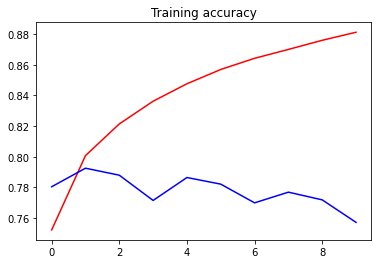

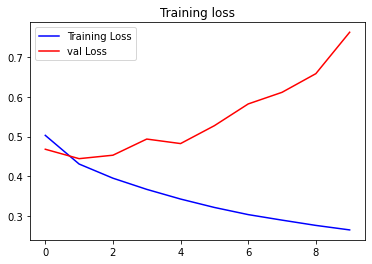

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='val Loss')
plt.title('Training loss')
plt.legend()

plt.show()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 54, 200)           31391800  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 54, 400)           641600    
_________________________________________________________________
dropout_20 (Dropout)         (None, 54, 400)           0         
_________________________________________________________________
lstm_40 (LSTM)               (None, 100)               200400    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 101       
Total params: 32,233,901
Trainable params: 32,233,901
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 800000 samples, validate on 200000 samples
Epoch 1/10
800000/800000 [==============================] - 374s 468us/step - loss: 0.4739 - accuracy: 0.7719 - val_loss: 0.4203 - val_accuracy: 0.8061
Epoch 2/10
800000/800000 [==============================] - 373s 466us/step - loss: 0.4031 - accuracy: 0.8173 - val_loss: 0.4181 - val_accuracy: 0.8120
Epoch 3/10
800000/800000 [==============================] - 373s 466us/step - loss: 0.3490 - accuracy: 0.8460 - val_loss: 0.4579 - val_accuracy: 0.8021
Epoch 4/10
800000/800000 [==============================] - 372s 465us/step - loss: 0.3077 - accuracy: 0.8655 - val_loss: 0.4997 - val_accuracy: 0.7895
Epoch 5/10
800000/800000 [==============================] - 371s 464us/step - loss: 0.2762 - accuracy: 0.8803 - val_loss: 0.5104 - val_accuracy: 0.8026
Epoch 6/10
800000/800000 [==============================] - 371s 464us/step - loss: 0.2497 - accuracy: 0.8927 - val_loss: 0.5531 - val_accuracy: 0.7923
Epoch 7/10
800000/800000 [==========

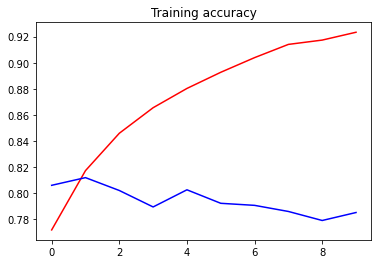

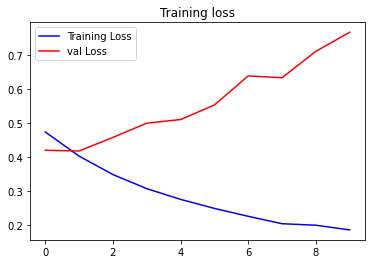

In [ ]:
rnn_emb = Sequential()

rnn_emb.add(Embedding(input_dim=unique_vocab+1, output_dim=embedding_dim, input_length=max_len, weights=[embedding_matrix]))

rnn_emb.add(Bidirectional (LSTM(units=embedding_dim, activation='relu',return_sequences=True)))
rnn_emb.add(Dropout(0.3))
rnn_emb.add(LSTM(100))

rnn_emb.add(Dense(1, activation='sigmoid'))

rnn_emb.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

rnn_emb.summary()

history=rnn_emb.fit(x_train_pad, y_train_pad, epochs=10, batch_size=2048, validation_data = (x_test_pad, y_test_pad))


import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='val Loss')
plt.title('Training loss')
plt.legend()

plt.show()